<h1>I'm something of a Painter Myself: CycleGAN</h1>

<p> In this notebook, we'll explore the process of using CycleGAN to convert images to the style of famous artist Claude Monet. CycleGAN is a powerful deep learning model capable of image-to-image translation without paired data. By leveraging unpaired datasets, CycleGAN can learn to map images from one domain to another, enabling us to transform photographs into Monet-style paintings</p>

<br>

<p>Resources:</p>
<a>https://www.tensorflow.org/tutorials/generative/cyclegan</a>
<br>
<a>https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook</a>

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

<h3>Loading Dependencies</h3>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from numpy.random import randn, randint
%matplotlib inline
from random import sample
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate, ZeroPadding2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras import initializers, layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import os
from PIL import Image
import cv2

from keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dense, AveragePooling2D, GaussianNoise
from keras.layers import Reshape, UpSampling2D, Activation, Dropout, Flatten, Conv2DTranspose
from keras.models import model_from_json, Sequential
from keras.optimizers import Adam
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow_examples.models.pix2pix import pix2pix
from IPython import display

<h3>Reading the image data</h3>

Using the tensor flow batch data class, we can store these images for easy batch analysis

In [3]:
monet_fn = tf.io.gfile.glob('dataset/monet_tfrec/*.tfrec')
photo_fn = tf.io.gfile.glob('dataset/photo_tfrec/*.tfrec')

In [4]:
#This code was used in Amy Jang's notebook (link above)
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset



Loading the Dataset

In [5]:
monet_ds = load_dataset(monet_fn, labeled=True).batch(1)
photo_ds = load_dataset(photo_fn, labeled=True).batch(1)

<h3>EDA: Brief look at Images </h3>

In [6]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

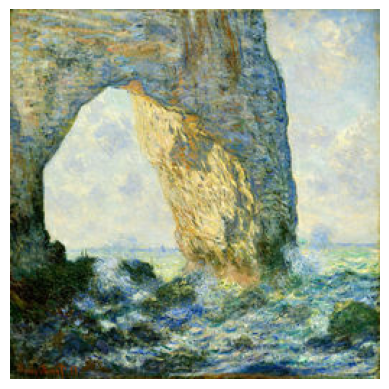

In [7]:
#Monet
plt.imshow(example_monet[0] * 0.5 + 0.5)
plt.axis('off')
plt.show()

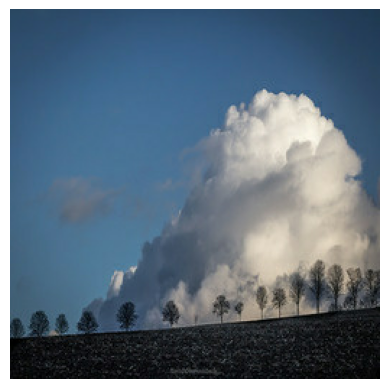

In [8]:
#Photo
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.axis('off')
plt.show()

<h3>Model Building</h3>

First step is to create the generator function and discriminator functions. In this notebook I used pix2pix's generator and discriminator for 256 x 256 x 3 images.

In [9]:
#Output channels (RGB)
OUTPUT_CHANNELS = 3

#Generator functions from pix2pix
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


Next we will need to define our loss functions

In [10]:
#Loss of object
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [11]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5


In [12]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)


In [13]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [14]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [15]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [16]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


In [17]:
EPOCHS = 2
#Iterate through the epochs and train the generator model
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    i = 0
    for image_x, image_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(image_x, image_y)
        if i % 10 == 0:
            print (str(i) + ' ')
        i = i + 1
    n += 1
    print('ending epoch')

0 
10 


KeyboardInterrupt: 

<h3>Results</h3>

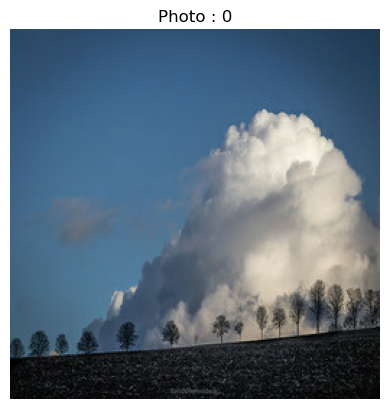

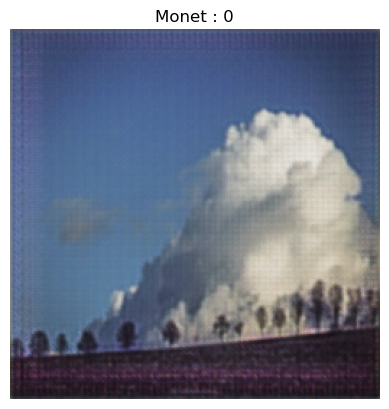

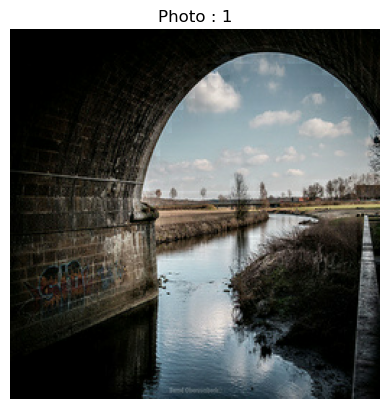

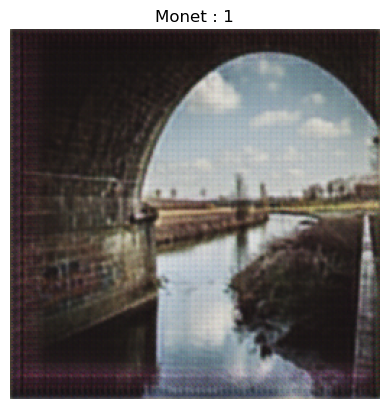

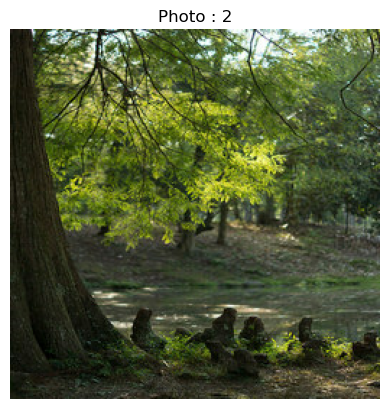

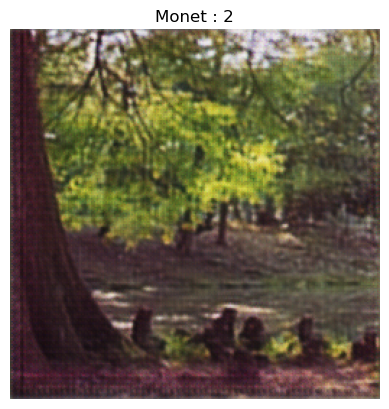

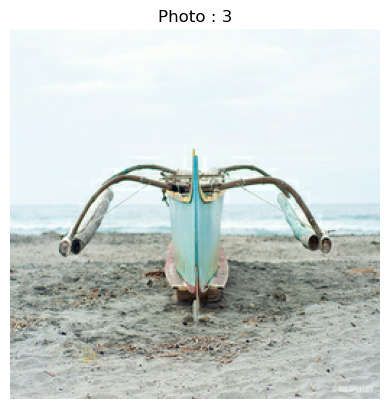

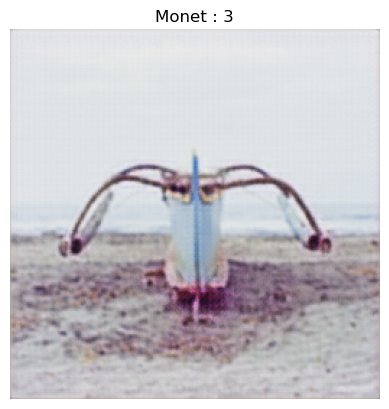

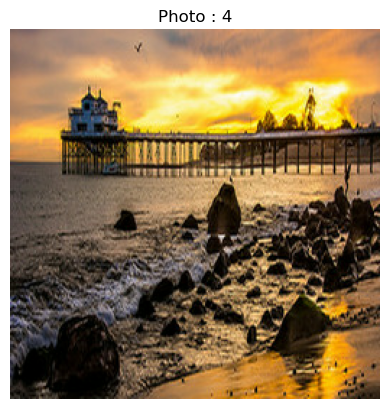

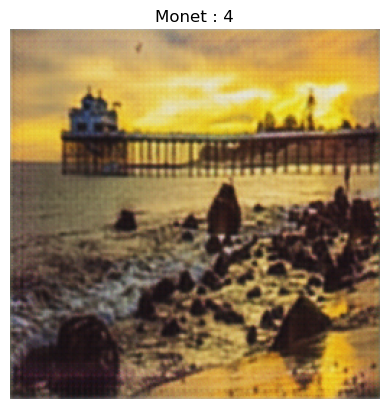

In [44]:
# Run the trained model on the test dataset
i = 0
for inp in photo_ds.take(5):
    pred = generator_g(inp, training=False)
    #photo
    plt.imshow(inp[0] * 0.5 + 0.5)
    plt.title('Photo : '  + str(i))
    plt.axis('off')
    plt.show()
    #Monet
    plt.imshow(pred[0] * 0.5 + 0.5)
    plt.title('Monet : ' + str(i))
    plt.axis('off')
    plt.show()
    i = i + 1

Code below taken from Amy Jang's notebook (link above)

In [51]:
j = 0
for inp in photo_ds:
    pred = generator_g(inp, training=False)
    pred_arr = np.array(pred[0])
    pred_array = (pred_arr * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(pred_array)
    im.save('output/' + str(j) + '.jpg')
    j = j + 1